# E-Commerce Strategic Analysis: Customer Retention & Value

## Executive Summary
This analysis transforms raw transaction data into actionable business insights regarding customer retention and value. By cleaning the data, removing outliers, and performing cohort analysis, we aim to answer critical questions about sustainable growth and customer segmentation.

## Phase 1: Data Engineering & SQL Setup

**Business Insight:**
By filtering out cancellations (Quantity <= 0) and invalid customer IDs at the SQL level, we ensure our analysis focuses on valid, completed transactions. This cleaner dataset forms the foundation for accurate revenue and retention modeling, preventing skewed metrics from failed or returned orders.

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_style("whitegrid")

# 1. Load CSV to SQLite
csv_file = 'online_retail_II.csv'
db_name = 'retail.db'

# Load CSV into chunks to avoid memory issues if large, but for this exercise we'll load directly if it fits.
# Given the file size (~94MB), it should fit in memory.
try:
    df_raw = pd.read_csv(csv_file)
    print(f"Raw data loaded: {df_raw.shape}")
except FileNotFoundError:
    print("Error: online_retail_II.csv not found.")

# Create SQLite connection
conn = sqlite3.connect(db_name)

# Write raw data to SQL
df_raw.to_sql('transactions', conn, if_exists='replace', index=False)
print("Data loaded into SQLite database.")

Raw data loaded: (1067371, 8)


Data loaded into SQLite database.


In [2]:
# 2. SQL Cleaning & Extraction
query = """
SELECT 
    Invoice, 
    StockCode, 
    Description, 
    Quantity, 
    InvoiceDate, 
    Price, 
    `Customer ID` as CustomerID,
    Country,
    (Quantity * Price) as TotalRevenue
FROM transactions
WHERE Quantity > 0
  AND `Customer ID` IS NOT NULL
"""

df = pd.read_sql(query, conn)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Cleaned data shape: {df.shape}")
df.head()

Cleaned data shape: (805620, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalRevenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## Phase 2: Statistical Analysis (NumPy)

**Business Insight:**
We apply statistical methods to remove outliers. Removing 'Whale' orders (Z-score > 3) prevents skewing our analysis by a few massive transactions. This ensures our insights apply to the typical customer base, which is more actionable for broad marketing strategies and product planning.

In [3]:
# 1. Outlier Removal (Z-Score)
# Calculate Z-scores for TotalRevenue
df['z_score'] = np.abs((df['TotalRevenue'] - df['TotalRevenue'].mean()) / df['TotalRevenue'].std())

# Filter out extreme "Whale" orders (Z-score > 3)
df_clean = df[df['z_score'] < 3].copy()

print(f"Data before outlier removal: {df.shape}")
print(f"Data after outlier removal: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} outliers.")

Data before outlier removal: (805620, 10)
Data after outlier removal: (804469, 10)
Removed 1151 outliers.


In [4]:
# 2. Cohort Matrix
# Get Cohort Month (Month of first purchase)
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.to_period('M')
df_clean['CohortMonth'] = df_clean.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Calculate Cohort Index (Months since first purchase)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

invoice_year, invoice_month = get_date_int(df_clean, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df_clean, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df_clean['CohortIndex'] = years_diff * 12 + months_diff + 1

# Create Cohort Matrix
cohort_data = df_clean.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

print("Cohort Matrix calculated.")
retention.head()

Cohort Matrix calculated.


CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.352941,0.335084,0.424370,0.381303,0.358193,0.377101,0.343487,0.335084,0.361345,...,0.298319,0.261555,0.300420,0.282563,0.258403,0.254202,0.314076,0.304622,0.406513,0.197479
2010-01,1.0,0.204188,0.314136,0.306283,0.264398,0.301047,0.259162,0.230366,0.280105,0.316754,...,0.154450,0.238220,0.198953,0.185864,0.198953,0.243455,0.193717,0.246073,0.057592,NaN
2010-02,1.0,0.236702,0.220745,0.289894,0.244681,0.199468,0.191489,0.284574,0.252660,0.271277,...,0.199468,0.159574,0.162234,0.143617,0.228723,0.228723,0.162234,0.058511,NaN,NaN
2010-03,1.0,0.190476,0.231293,0.242630,0.233560,0.206349,0.247166,0.301587,0.276644,0.108844,...,0.170068,0.172336,0.156463,0.179138,0.201814,0.210884,0.079365,NaN,NaN,NaN
2010-04,1.0,0.194539,0.194539,0.163823,0.180887,0.225256,0.276451,0.262799,0.105802,0.109215,...,0.156997,0.136519,0.150171,0.180887,0.225256,0.058020,NaN,NaN,NaN,NaN


## Phase 3: The "Perfect Storytelling" Visualization

We will now generate three specific plots to answer key business questions.

/var/folders/sp/z0w32jpj0jlflqt1ltcpcmm40000gn/T/ipykernel_91661/1679498240.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_metrics = df_clean.set_index('InvoiceDate').resample('M').agg({


/var/folders/sp/z0w32jpj0jlflqt1ltcpcmm40000gn/T/ipykernel_91661/1679498240.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


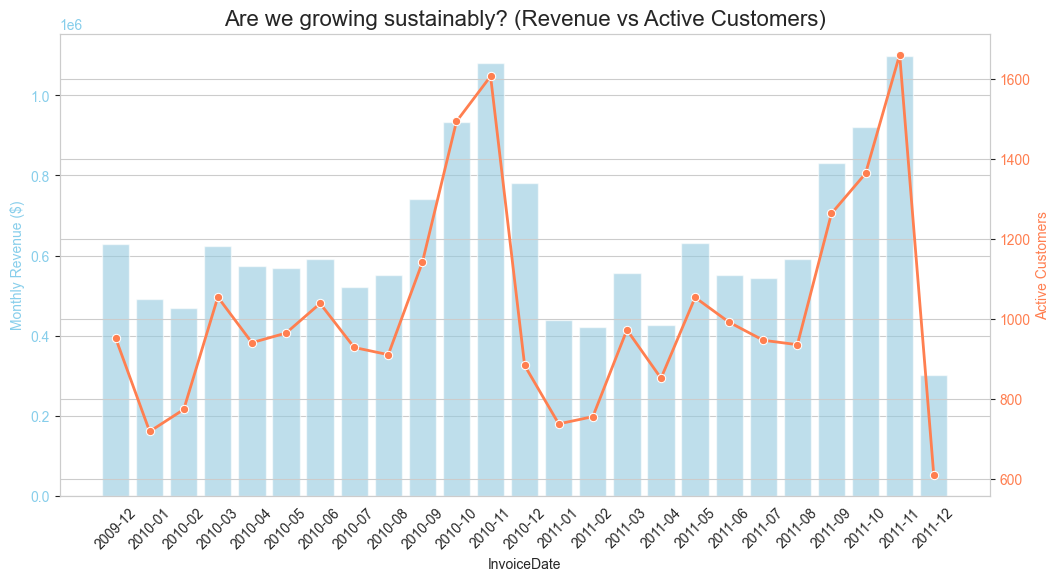

In [5]:
# Plot A: "Are we growing sustainably?" (Dual Axis Chart)

# Resample to monthly
monthly_metrics = df_clean.set_index('InvoiceDate').resample('M').agg({
    'TotalRevenue': 'sum',
    'CustomerID': 'nunique'
})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart (Revenue)
sns.barplot(x=monthly_metrics.index.strftime('%Y-%m'), y=monthly_metrics['TotalRevenue'], ax=ax1, color='skyblue', alpha=0.6)
ax1.set_ylabel('Monthly Revenue ($)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Line Chart (Active Customers)
ax2 = ax1.twinx()
sns.lineplot(x=monthly_metrics.index.strftime('%Y-%m'), y=monthly_metrics['CustomerID'], ax=ax2, color='coral', marker='o', linewidth=2)
ax2.set_ylabel('Active Customers', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

plt.title('Are we growing sustainably? (Revenue vs Active Customers)', fontsize=16)
plt.show()

**Business Insight (Plot A):**
This dual-axis chart reveals the relationship between revenue growth and customer acquisition. If revenue rises while active customers flatline, we are extracting more value per user (higher LTV). If both rise, we are in a healthy growth phase. Divergence where customers increase but revenue flatlines could indicate a drop in average order value.

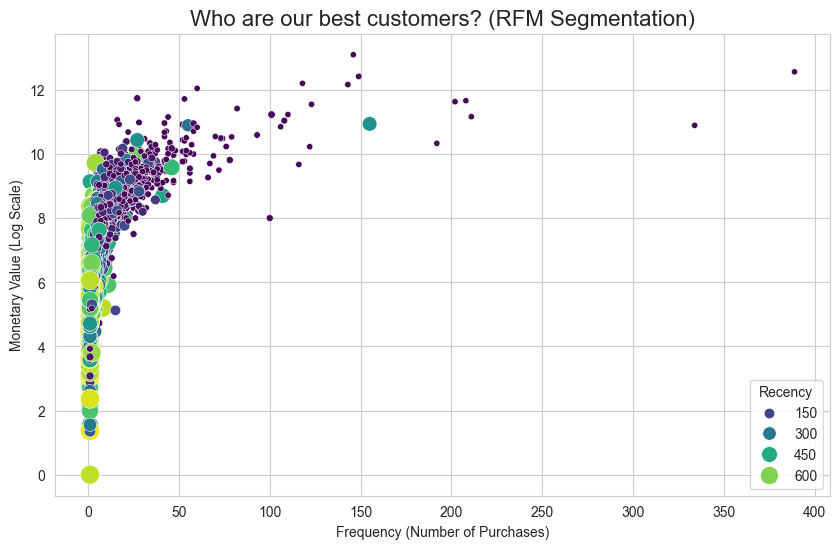

In [6]:
# Plot B: "Who are our best customers?" (RFM Segmentation)

# Calculate RFM
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalRevenue': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalRevenue': 'Monetary'}, inplace=True)

# Log Transformation for Monetary
rfm['MonetaryLog'] = np.log1p(rfm['Monetary'])

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='MonetaryLog', hue='Recency', palette='viridis', size='Recency', sizes=(20, 200))
plt.title('Who are our best customers? (RFM Segmentation)', fontsize=16)
plt.xlabel('Frequency (Number of Purchases)')
plt.ylabel('Monetary Value (Log Scale)')
plt.show()

**Business Insight (Plot B):**
The RFM segmentation highlights our 'Champions' in the top right (High Frequency, High Monetary). The color gradient indicates Recency. 'At Risk' customers are those with high frequency/monetary values but dark colors (high recency, meaning they haven't bought in a while). These are prime targets for re-engagement campaigns.

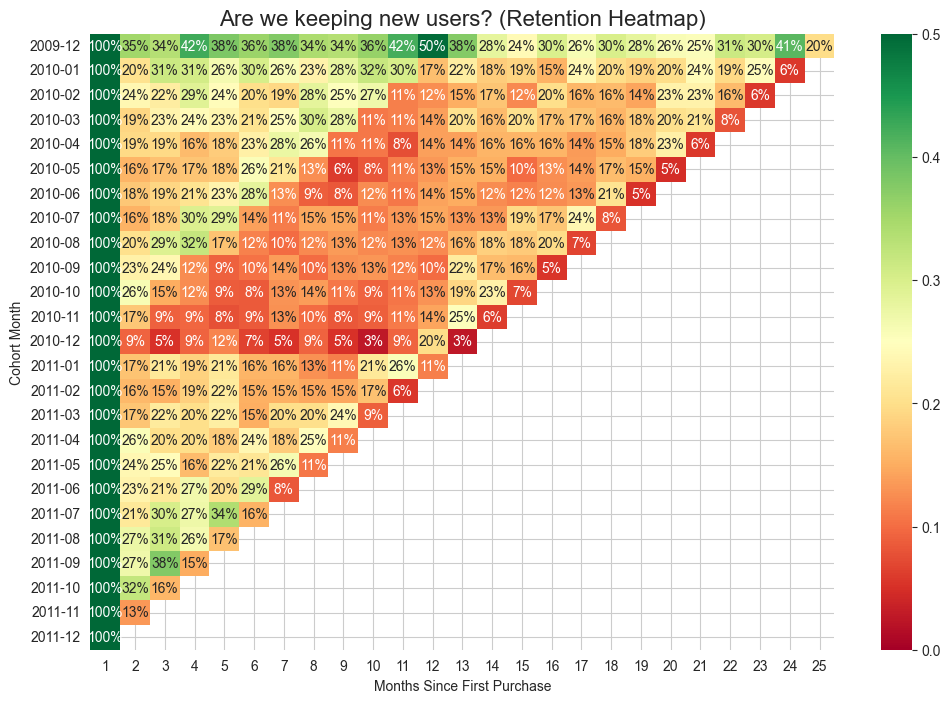

In [7]:
# Plot C: "Are we keeping new users?" (Retention Heatmap)

plt.figure(figsize=(12, 8))
plt.title('Are we keeping new users? (Retention Heatmap)', fontsize=16)
sns.heatmap(retention, annot=True, fmt='.0%', cmap='RdYlGn', vmin=0.0, vmax=0.5)
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()

**Business Insight (Plot C):**
The heatmap visualizes the 'leaky bucket'. A sharp drop-off in retention percentages in the first few months indicates a need for better onboarding or early-stage engagement. High retention rates in later months for older cohorts suggest a loyal core user base, while newer cohorts showing lower retention might indicate recent quality issues or market saturation.